## Diffusers and Small Diffusion 1

In [1]:
from smalldiffusion import ScheduleLDM, samples
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from typing import Optional, Union, Tuple
from itertools import pairwise


In [2]:
import torch
from accelerate import Accelerator
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from diffusers.utils.import_utils import is_xformers_available
from transformers import CLIPTextModel, CLIPTokenizer
from torch import nn

from smalldiffusion import ModelMixin

def alpha_bar(sigma):
    return 1/(sigma**2+1)

class ModelLatentDiffusion(nn.Module, ModelMixin):
    def __init__(self, model_key, accelerator=None):
        super().__init__()
        self.accelerator = accelerator or Accelerator()
        self.vae = AutoencoderKL.from_pretrained(model_key, subfolder="vae")
        self.tokenizer = CLIPTokenizer.from_pretrained(model_key, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(model_key, subfolder="text_encoder")
        self.unet = UNet2DConditionModel.from_pretrained(model_key, subfolder="unet")
        self.scheduler = DDIMScheduler.from_pretrained(model_key, subfolder="scheduler")
        self.input_dims = (self.unet.in_channels, self.unet.sample_size, self.unet.sample_size,)
        self.text_condition = None
        self.text_guidance_scale = None
        if is_xformers_available():
            self.unet.enable_xformers_memory_efficient_attention()
        self.to(self.accelerator.device)

    def tokenize(self, prompt):
        return self.tokenizer(
            prompt, padding='max_length', max_length=self.tokenizer.model_max_length,
            truncation=True, return_tensors='pt'
        ).input_ids.to(self.accelerator.device)

    def set_text_condition(self, prompt, negative_prompt='', text_guidance_scale=7.5):
        with torch.no_grad():
            prompt_emb = self.text_encoder(self.tokenize(prompt))[0]
            uncond_emb = self.text_encoder(self.tokenize(negative_prompt))[0]
        self.text_condition = torch.cat([uncond_emb, prompt_emb])
        self.text_guidance_scale = text_guidance_scale

    @torch.no_grad()
    def decode_latents(self, latents):
        return self.vae.decode(latents / 0.18215).sample

    def sigma_to_t(self, sigma):
        idx = torch.searchsorted(reversed(self.scheduler.alphas_cumprod.to(sigma)), alpha_bar(sigma))
        return self.scheduler.num_train_timesteps - 1 - idx

    def forward(self, x, sigma, cond=None):
        z = alpha_bar(sigma).sqrt() * x
        z2 = torch.cat([z, z])
        eps = self.unet(z2, self.sigma_to_t(sigma), encoder_hidden_states=self.text_condition).sample
        eps_uncond, eps_prompt = eps.chunk(2)
        return eps_prompt + self.text_guidance_scale * (eps_prompt - eps_uncond)

In [3]:
schedule = ScheduleLDM(1000)
model    = ModelLatentDiffusion('stabilityai/stable-diffusion-2-1-base')

/tmp/ipykernel_6420/3778479164.py:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  self.input_dims = (self.unet.in_channels, self.unet.sample_size, self.unet.sample_size,)


In [4]:
# model.set_text_condition('An astronaut riding a horse')
model.set_text_condition("A lone tree standing in the middle of a desert, under the harsh light of midday, casting a long shadow on the sand.")

In [90]:
model.to('cuda');
gam=1.0
mu=0.0 #0.5 is DDPM
cfg_scale=0.0
cond=None
sigmas=schedule.sample_sigmas(50)
batch_size=1
# xt_history=[]
# heatmaps=[]
eps=None
torch.manual_seed(25)


with torch.no_grad():
    model.eval();
    xt=torch.randn((batch_size,) + model.input_dims)*sigmas[0] #Scaling by sigma here matters a lot - why is that???
    for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
        eps_prev, eps = eps, model.predict_eps_cfg(xt.to('cuda'), sig.to('cuda'), cond, cfg_scale)
        # eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt.to('cuda') - (sig - sig_p) * eps + eta * model.rand_input(xt.shape[0]).to('cuda') #Straight remove adding random noise
        # xt_history.append(xt.numpy())
        # heatmaps.append(model.forward(grid, sig, cond=None))
x0=xt
# xt_history=np.array(xt_history)

In [91]:
# *xts, x0 = samples(model, schedule.sample_sigmas(50))

In [92]:
decoded  = model.decode_latents(x0)

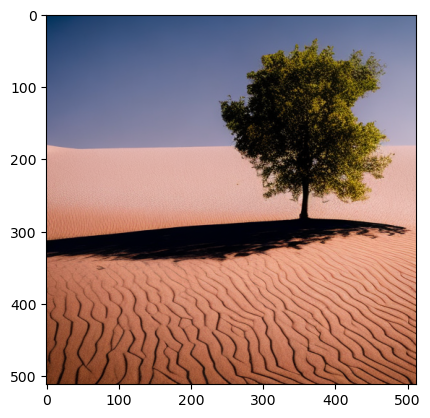

In [93]:
im=((decoded.squeeze()+1)/2).clamp(0,1)
plt.imshow(im.cpu().numpy().transpose((1,2,0)))

In [52]:
eta

tensor(0.)

In [11]:


# save_image(((decoded.squeeze()+1)/2).clamp(0,1), 'stablediffusion_output.png')

In [12]:
!ls

 colorbar.png				  man_man.png
 deprecated_p17_27.ipynb		  me_no_hat_cropped_1.jpeg
'Diffusers and Small Diffusion 1.ipynb'   me_with_hat.jpeg
'Diffusers Hacking 1.ipynb'		  n02099601_7101.jpg
 embedding_a_photo_of_a_cat.png		  n02123045_1955.jpg
 embedding_a_photo_of_a_dog.png		  p17_27.ipynb
 embedding_a_photo_of_a_man.png		 'Toy Datasets 1.ipynb'
 embedding_cat.png			 'Toy Sampling Animations 1.ipynb'
 embedding_dog.png			 'Toy Sampling Animations 2b.ipynb'
 embedding_me_no_hat_cropped_1.png	 'Toy Sampling Animations 2.ipynb'
 hackin					 'Toy Sampling Animations 3.ipynb'
 logos
